In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

ac05fc6aaa4de36d119eed13b453ee1c
total frames  50
9cda8d69621f0ce3fce8765823b8d02a
total frames  50
2ad2276dad53fc38c19eb307fc103c4e
total frames  50
bacdf30b503ff3c080d2dce771bbed33
total frames  50
c6e7ccf2110244b94586ab9aa27dd4a9
total frames  50
952f0a63a6a09c168dd546a742c2a6e0
total frames  50
e8dc2fe20424c443c2f43e02d120a0f2
total frames  50
bc07d268608a1efdd7d352eba77ee211
total frames  50
2ac2c9ed1d01f19be603ab276afdc17c
total frames  50
4cc066091feb08f1114e7020069ce0bf
total frames  50
4454eae3b23c2bf604fa6d99e8d37194
total frames  50
61773048fb15a300d626302dbd0ccf52
total frames  50
86b0dd12154726fd3df4b7691c0db458
total frames  50
0a91e48ecf0fd55f3ecc05042a6c5f15
total frames  50
e43aca2a3064211564e91e7dd9d349a2
total frames  50
d13618d8396356051ef7633b25fe3e7a
total frames  50
ede694e638b3b8e96eeca6b97fb2573f
total frames  50


/Users/monetalberts/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


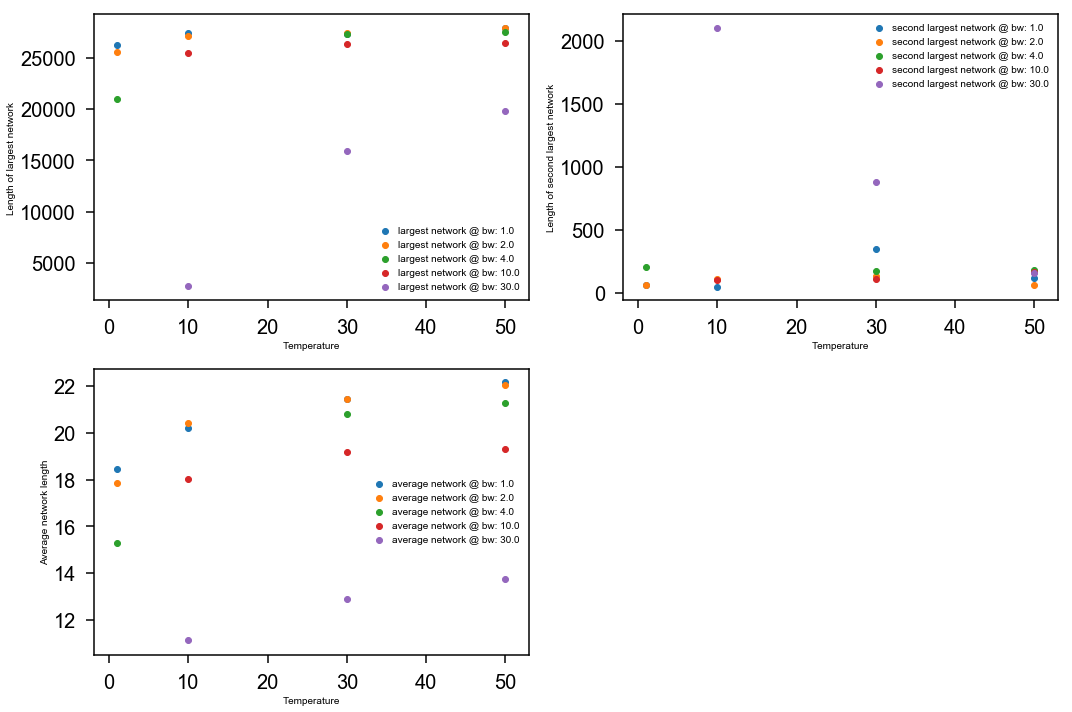

In [27]:
import signac
import gsd
import gsd.fl
import gsd.hoomd
import networkx as nx
import numpy as np
from freud import box, density
import matplotlib.pyplot as plt
%matplotlib inline

def get_status(job):
    status = 'init'
    if job.isfile('final.hoomdxml') and job.isfile('data.gsd'):
        status = 'job-computed'
    elif job.isfile('temperature_profile.png'):
        status = 'temperature-profile-created'

    return status

project = signac.init_project('ABCTypeEpoxy', '/Users/monetalberts/Projects/Epoxy_sim/bondweight_runs/bondweight_study/data')


sbws = [1.0, 2.0, 4.0, 10.0, 30.0]
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
#fig, ax1 = plt.subplots(figsize=(15,10))
for sbw in sbws:
    kTs=[]
    largest_networks = []
    second_largest_networks = []
    average_network_lens = []

    jobs = project.find_jobs({'activation_energy':1.0, 'sec_bond_weight':sbw})
    for job in jobs:
        #print(job)
        job_status = get_status(job)
        if job_status == 'job-computed' and job.get_id() !='6378fac29834215b7ae2ef2f9190e2ae':
            #print('final state points: {} time step, {} kT, status:{}'.format(job.sp.temp_prof[-1][0],job.sp.temp_prof[-1][1],job_status))
            print(job)
            kTs.append(job.sp.temp_prof[-1][1])
            f = gsd.fl.GSDFile(job.fn('data.gsd'), 'rb')
            t = gsd.hoomd.HOOMDTrajectory(f)
            n_frames = len(t)
            print('total frames ',n_frames)
            connected_components = []
            last_frame = n_frames-1
            snapshot = t[last_frame]
            sim_box = snapshot.configuration.box
            fbox = box.Box(Lx=sim_box[0], Ly=sim_box[1], Lz=sim_box[2])
            bonds = snapshot.bonds.group
            G = nx.MultiGraph(ts='time_step:{}, kT:{}'.format(last_frame,job.sp.temp_prof[-1][1]))
            G.graph
            for bond in bonds:
                G.add_edge(bond[0],bond[1])
            n_connected = nx.number_connected_components(G)
            largest_cc = max(nx.connected_components(G), key=len)
            connected_components.append(n_connected)
            largest_networks.append(len(largest_cc))
            sorted_cc = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
            second_largest_networks.append(sorted_cc[1])
            average_network_lens.append(np.mean(sorted_cc))
            
    ax1.scatter(kTs, largest_networks,linestyle='-',marker='o',label='largest network @ bw: {}'.format(sbw))
    ax2.scatter(kTs, second_largest_networks,linestyle='-',marker='o',label='second largest network @ bw: {}'.format(sbw))
    ax3.scatter(kTs, average_network_lens,linestyle='-',marker='o',label='average network @ bw: {}'.format(sbw))
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Length of largest network')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Length of second largest network')
ax3.set_xlabel('Temperature')
ax3.set_ylabel('Average network length')
fig.tight_layout()
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()